In [1]:
import numpy as np
from numpy.linalg import lstsq

ramp = lambda u: np.maximum( u, 0 )
step = lambda u: ( u > 0 ).astype(float)

def SegmentedLinearReg( X, Y, breakpoints ):
    nIterationMax = 10

    breakpoints = np.sort( np.array(breakpoints) )

    dt = np.min( np.diff(X) )
    ones = np.ones_like(X)

    for i in range( nIterationMax ):
        # Linear regression:  solve A*p = Y
        Rk = [ramp( X - xk ) for xk in breakpoints ]
        Sk = [step( X - xk ) for xk in breakpoints ]
        A = np.array([ ones, X ] + Rk + Sk )
        p =  lstsq(A.transpose(), Y, rcond=None)[0] 

        # Parameters identification:
        a, b = p[0:2]
        ck = p[ 2:2+len(breakpoints) ]
        dk = p[ 2+len(breakpoints): ]

        # Estimation of the next break-points:
        newBreakpoints = breakpoints - dk/ck 

        # Stop condition
        if np.max(np.abs(newBreakpoints - breakpoints)) < dt/5:
            break

        breakpoints = newBreakpoints
    else:
        print( 'maximum iteration reached' )

    # Compute the final segmented fit:
    Xsolution = np.insert( np.append( breakpoints, max(X) ), 0, min(X) )
    ones =  np.ones_like(Xsolution) 
    Rk = [ c*ramp( Xsolution - x0 ) for x0, c in zip(breakpoints, ck) ]

    Ysolution = a*ones + b*Xsolution + np.sum( Rk, axis=0 )
    print("break points:", breakpoints)

    return Xsolution, Ysolution

/Users/jhkim/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


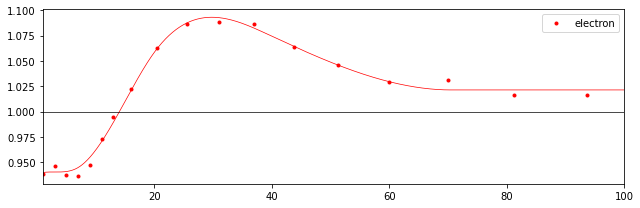

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

from patsy import dmatrix
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import optimize

np.random.seed(0)

x_ = np.linspace(-1, 1, 2000)
y_ = np.cos(x_) + 0.3*np.random.rand(2000)

x = np.array([1.,3.,5.,7.,9.,11.,13.,16.,20.5,25.5,31.,37.,43.75,51.25,60.,70.,81.25,93.75])
# region 2
y = np.array([0.93798484, 0.9465644,  0.93694724, 0.93641232, 0.94720683, 0.97291458,
            0.99444424, 1.02197827, 1.0625216,  1.08631556, 1.08899024, 1.08700386,
              1.06341353, 1.04584694, 1.02962848, 1.0312275,  1.01668811, 1.01632768])

y_muon = np.array([0.93567666, 0.94973207, 0.93676095, 0.93446826, 0.94815744, 0.97089251,
                   0.99758456, 1.02561451, 1.05964713, 1.08903241, 1.09468342, 1.08065525,
                   1.06544626, 1.04263896, 1.03402147, 1.02252066, 1.01610139, 1.00448026
                  ])

# region 2 2017
#y = np.array([1.32737966, 1.26082732, 1.13012394, 1.00433466, 0.93384785, 0.89905102,
#             0.88466971, 0.87854865, 0.89107385, 0.91722749, 0.96068111, 0.98304949,
#             0.99861931, 0.99186079, 0.99654658, 0.9938622,  0.99091709, 0.99159343])

#y_muon = np.array([1.33624175, 1.26272433, 1.1148753,  0.98756807, 0.91943575, 0.89285799,
#                  0.88040464, 0.87792476, 0.89418432, 0.91656885, 0.95840803, 0.996465,
#                  1.00440976, 1.00631142, 0.99851868, 1.00192182, 0.99763982, 0.99611084])

# region 3 2018

#y = np.array([1.32032365, 1.25049125, 1.12647904, 1.00178303, 0.92927389, 0.89790256,
#             0.87491761, 0.87062492, 0.88419814, 0.91011939, 0.95739222, 1.00234957,
#             1.01845783, 1.02222449, 1.02262733, 1.02960845, 1.02640614, 1.0505977])

#y_muon = np.array([1.32750368, 1.2564965,  1.11297694, 0.98227927, 0.91680713, 0.88913029,
#             0.87571188, 0.87319709, 0.88466552, 0.91290644, 0.95912749, 1.00751859,
#             1.0234516,  1.0253404,  1.02599019, 1.03562598, 1.04338227, 1.0346472])

# region 0
#y = np.array([0.86801505, 0.9291349,  0.90651866, 0.91523914, 0.94960936, 0.93381399,
#             0.97986787, 0.97427153, 1.02922837, 1.02955109, 1.04358923, 1.01337227,
#             1.03766124, 0.97928631, 0.96224762, 0.96398895, 1.09229753, 0.88968224])

# region 1
#y = np.array([0.9009115,  0.90355784, 0.90372454, 0.91365913, 0.91517393, 0.94715262,
#             0.95827249, 0.97294396, 1.00659279, 1.03722108, 1.04279975, 1.02264748,
#             1.0292197,  1.0259291,  0.98410816, 0.98750379, 0.91472193, 0.97399101])

# region 3
#y = np.array([0.90753963, 0.90949884, 0.90251483, 0.90349954, 0.92324253, 0.92151621,
#             0.95480787, 0.96552632, 1.00808998, 1.06997776, 1.05816545, 1.02598357,
#             0.99142115, 0.9772264,  0.9970756,  1.00455321, 0.95007573, 0.98454824])

# region 4
#y = np.array([0.78477745, 0.79211599, 0.7816137,  0.85813896, 0.85332221, 0.85535435,
#             0.85231623, 0.95423788, 0.95117381, 0.96447854, 1.0094746,  0.83440693,
#             0.99233016, 0.9598667,  0.84213592, 0.85708658, 1.01650119, 1.01429231])

# region 5
#y = np.array([0.72727193, 0.65211503, 0.80169465, 0.7001711,  0.80150568, 0.94195794,
#             0.88946919, 0.86939669, 0.81453333, 0.86482016, 0.86524934, 1.06928487,
#             1.03454639, 0.91340263, 1.07544811, 0.87615795, 0.9457523,  1.24813963])

'''
x = np.array([ 
       107.  , 109.  , 111.25, 113.75, 116.25, 118.75, 121.5 , 124.5 ,
       127.75, 131.25, 135.  , 139.  , 143.25, 147.75, 152.5 , 157.5 ,
       162.75, 168.25, 174.5 , 181.5 , 188.75, 196.25, 205.  , 215.  ,
       225.75, 237.25, 250.5 , 265.5 , 284.75, 308.25, 335.  , 365.  ,
       395.  , 425.  , 457.5 , 492.5 , 532.5 , 577.5 , 625.  , 675.  ,
 ])

y = np.array([
        1.43421613e+03,  6.61367049e+02,  2.91763752e+02,  1.96630592e+02,
        1.21241411e+02,  9.98337908e+01,  7.28460606e+01,  6.21572586e+01,
        5.31752071e+01,  2.11735073e+01,  3.34063610e+01,  3.82002216e+01,
        2.44379701e+01,  1.25210061e+01,  9.10271207e+00,  1.12138593e+01,
        1.09894106e+01,  3.42602104e+00,  4.37388898e+00,  2.54843816e+00,
        3.68718215e+00,  2.70034712e+00,  1.52584234e-01,  2.48591507e+00,
        1.06995300e+00,  1.03321264e+00,  1.20127987e+00,  1.44953143e+00,
        5.33837005e-01,  1.31092324e+00,  4.26358049e-01,  8.22622755e-01,
        9.14337903e-01,  2.49502366e-02,  1.18326229e-01,  3.71319698e-02,
        5.14912805e-03,  2.89915789e-02,  2.89915789e-02,  3.13763539e-02,
 ])
'''

p_che = np.polynomial.Chebyshev.fit(x, y, 3)

initialBreakpoints = [1, 60]
#plt.plot( *SegmentedLinearReg( x, y, initialBreakpoints ), 'k--', lw=1);

xp = np.linspace(1, 1000, 10000)

# Generating cubic spline with 3 knots at 25, 40 and 60
transformed_x = dmatrix("bs(train, knots=(10, 12.5, 20, 40), degree=3, include_intercept=False)", {"train": x})
#transformed_x = dmatrix("cr(x, df=6, knots=[13, 20, 35, 50])")

# Fitting Generalised linear model on transformed dataset
fit1 = sm.GLM(y, transformed_x).fit()
# Prediction
#pred1 = fit1.predict(dmatrix("bs(valid, knots=(10, 12.5, 20, 40), include_intercept=False)", {"valid": xp}))
#pred1 = fit1.predict(dmatrix("cr(xp, df=6,knots=[13, 20, 35, 50])"))


fig, ax = plt.subplots(figsize=(9,3))

#ax.plot(xp, pred1, 'k--', label='Specifying degree =3 with 3 knots')

# region 0
#cut = 11.
#cut2 = 20.
#cut3 = 40
#cut4 = 60

# region 1
#cut = 7.
#cut2 = 18.
#cut3 = 60
#cut4 = 68

# region 2
cut = 7.
cut2 = 20.
cut3 = 40
cut4 = 70

# region 3
#cut = 11.
#cut2 = 20.
#cut3 = 40
#cut4 = 65

# region 4
#cut = 11.
#cut2 = 20.
#cut3 = 35
#cut4 = 35

# region 5
#cut = 11.
#cut2 = 20.
#cut3 = 35
#cut4 = 35

def piecewise_linear(x, a00, a01, a02, a03, a13, a23, a33, a43):
    
    
    return np.piecewise(x, [x < cut, x > cut, x > cut2, x > cut3, x > cut4], [
                                                          lambda x: a00 + a01 * x + a02 * x**2 + a03 * x**3,      
                                                          lambda x: a00 + cut**3 * (a03-a13) + (a01 - 3 * cut**2*(a03-a13)) * x + (a02 + 3 * cut * (a03-a13)) * x**2 + a13 * x **3,
                                                          lambda x: (a00 + cut**3 * (a03-a13)) + cut2**3 * (a13-a23) + ((a01 - 3 * cut**2*(a03-a13)) - 3 * cut2**2*(a13-a23)) * x + ((a02 + 3 * cut * (a03-a13)) + 3 * cut2 * (a13-a23)) * x**2 + a23 * x**3,
        
                                                          lambda x: ((a00 + cut**3 * (a03-a13)) + cut2**3 * (a13-a23)) + cut3**3 * (a23-a33) + \
                                                                    ( ((a01 - 3 * cut**2*(a03-a13)) - 3 * cut2**2*(a13-a23)) - 3 * cut3**2*(a23-a33) ) * x + \
                                                                    ( ((a02 + 3 * cut * (a03-a13)) + 3 * cut2 * (a13-a23)) + 3 * cut3 * (a23-a33)) * x**2 + \
                                                                    a33 * x**3,
                                                          lambda x: ((a00 + cut**3 * (a03-a13)) + cut2**3 * (a13-a23)) + cut3**3 * (a23-a33) + \
                                                                    ( ((a01 - 3 * cut**2*(a03-a13)) - 3 * cut2**2*(a13-a23)) - 3 * cut3**2*(a23-a33) ) * cut4+ \
                                                                    ( ((a02 + 3 * cut * (a03-a13)) + 3 * cut2 * (a13-a23)) + 3 * cut3 * (a23-a33)) * cut4**2 + \
                                                                    a33 * cut4**3,
                                                         ])
'''

cut = 300
def piecewise_linear(x, a, b, c, d, e, f, g, h, i, j):
    
    
    return np.piecewise(x, [x < cut], [
                                       lambda x:  
                                                   (x **(a + b * np.log(x)))  \
                                                   + (x **(c + d * np.log(x))) \
                                                   #+(x **(e + f * np.log(x)))  \
        
                                                   #+ g * (1 + (h * x** 2 + i * x**3))** j,
                                    
    ])

p, e = optimize.curve_fit(piecewise_linear, x, y)
#p_muon, e_muon = optimize.curve_fit(piecewise_linear, x, y_muon)
ax.set_yscale("log")  
#ax.set_xscale("log")

#y_test = np.exp(-0.01*xp)
y_test = (xp **(p[0] + p[1] * np.log(xp)))  \
       + (xp **(p[2] + p[3] * np.log(xp))) \
       + (xp **(p[4] + p[5] * np.log(xp)))  \
       + p[6] * (1 + (p[7] * xp** 2 + p[8] * xp**3))** p[9]

'''
p, e = optimize.curve_fit(piecewise_linear, x, y)
#ax.set_ylim(1e-10, 1e20) 
ax.set_xlim(1, 100) 
ax.plot(x, y, 'r.', label="electron")
#ax.plot(xp, y_test, 'b--', linewidth = 0.7)
#ax.plot(x, y_muon, 'b.', label="muon")
#plt.plot(x, p(x), 'k-', lw=1)
ax.axhline(1., color='black', linewidth=0.7, zorder=5)
ax.plot(xp, piecewise_linear(xp, *p), 'r-', linewidth=0.7)
#ax.plot(xp, y_test, 'b--', linewidth = 0.7)
#ax.plot(xp, piecewise_linear(xp, *p_muon), 'b-', linewidth=0.5)
plt.tight_layout()
plt.legend(loc='upper right')
plt.savefig("zptweight.pdf", format="pdf", dpi=300) 


In [12]:
p

array([ 1.10248537e+01, -2.11844405e+00,  4.69167431e+00, -8.62982426e-01,
        5.48108769e+01, -1.14041724e+01, -3.87159114e+06,  3.08649514e+09,
       -3.87386240e+06, -7.64504326e+06])

# Piecese-wise fit

In [ ]:
# import modules
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt 
%matplotlib inline

In [ ]:
# read data_set
data = pd.read_csv("/Users/jhkim/Downloads/Wage.csv")

In [ ]:
data.head()

In [ ]:
data_x = np.array(data['age'])
data_y = np.array(data['wage'])

In [ ]:
data_x

In [ ]:
# Dividing data into train and validation datasets
from sklearn.model_selection import train_test_split
train_x, valid_x, train_y, valid_y = train_test_split(data_x, data_y, test_size=0.33, random_state = 1)

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(train_x, train_y, facecolor='None', edgecolor='k', alpha=0.3)
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression

# Fitting linear regression model
x = np.array(train_x).reshape(-1,1)
model = LinearRegression()
model.fit(x, np.array(train_y))
print(model.coef_)
print(model.intercept_)

In [ ]:
type(np.array(train_x))

In [ ]:
# Prediction on validation dataset
valid_x = np.array(valid_x).reshape(-1,1)
pred = model.predict(valid_x)

In [ ]:
# Visualisation
# We will use 70 plots between minimum and maximum values of valid_x for plotting
xp = np.linspace(valid_x.min(),valid_x.max(),70)
xp = xp.reshape(-1,1)
pred_plot = model.predict(xp)

plt.scatter(valid_x, valid_y, facecolor='None', edgecolor='k', alpha=0.3)
plt.plot(xp, pred_plot)
plt.show()

In [ ]:
# Generating weights for polynomial function with degree =2
weights = np.polyfit(train_x, train_y, 2)
print(weights)



In [ ]:
# Generating model with the given weights
model = np.poly1d(weights)

In [ ]:
# Prediction on validation set
pred = model(valid_x)
# We will plot the graph for 70 observations only
xp = np.linspace(valid_x.min(),valid_x.max(),70)
pred_plot = model(xp)
plt.scatter(valid_x, valid_y, facecolor='None', edgecolor='k', alpha=0.3)
plt.plot(xp, pred_plot)
plt.show()

In [ ]:
# Dividing the data into 4 bins
df_cut, bins = pd.cut(train_x, 4, retbins=True, right=True)
df_cut.value_counts(sort=False)

In [ ]:
df_steps = pd.concat([train_x, df_cut, train_y], keys=['age','age_cuts','wage'], axis=1)

# Create dummy variables for the age groups
df_steps_dummies = pd.get_dummies(df_cut)
df_steps_dummies.head()

In [ ]:
from patsy import dmatrix
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
# Generating cubic spline with 3 knots at 25, 40 and 60
transformed_x = dmatrix("bs(train, knots=(25,40,60), degree=3, include_intercept=False)", {"train": train_x})


In [ ]:
# Fitting Generalised linear model on transformed dataset
fit1 = sm.GLM(train_y, transformed_x).fit()

In [ ]:
# Generating cubic spline with 4 knots
transformed_x2 = dmatrix("bs(train, knots=(25,40,50,65),degree =3, include_intercept=False)", {"train": train_x})

In [ ]:
# Fitting Generalised linear model on transformed dataset
fit2 = sm.GLM(train_y, transformed_x2).fit()

In [ ]:
# Predictions on both splines
pred1 = fit1.predict(dmatrix("bs(valid, knots=(25,40,60), include_intercept=False)", {"valid": valid_x}))
pred2 = fit2.predict(dmatrix("bs(valid, knots=(25,40,50,65),degree =3, include_intercept=False)", {"valid": valid_x}))

In [ ]:
# We will plot the graph for 70 observations only
xp = np.linspace(valid_x.min(),valid_x.max(),70)

# Make some predictions
pred1 = fit1.predict(dmatrix("bs(xp, knots=(25,40,60), include_intercept=False)", {"xp": xp}, return_type='dataframe'))
pred2 = fit2.predict(dmatrix("bs(xp, knots=(25,40,50,65),degree =3, include_intercept=False)", {"xp": xp}, return_type='dataframe'))

# Plot the splines and error bands
plt.scatter(data.age, data.wage, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(xp, pred1, label='Specifying degree =3 with 3 knots')
plt.plot(xp, pred2, color='r', label='Specifying degree =3 with 4 knots')
plt.legend()
plt.xlim(15,85)
plt.ylim(0,350)
plt.xlabel('age')
plt.ylabel('wage')
plt.show()

In [ ]:
type(transformed_x)

In [ ]:
transformed_x

In [ ]:
type(train_x)

In [ ]:
train_x

In [ ]:
pred1